In [1]:
import skimage.external.tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.utils.data as dataf
import torch.nn as nn

from sklearn.metrics import f1_score, cohen_kappa_score, accuracy_score

## Data

In [2]:
Data = tiff.imread('data/CASI_SC_tif.tif')
TsLabel = tiff.imread('data/Test_sample.tif')
TrLabel = tiff.imread('data/Train_samples.tif')

In [3]:
patchsize = 16  # input spatial size for 2D-CNN
batchsize = 128  # select from [16, 32, 64, 128], the best is 64
EPOCH = 200
LR = 0.001

In [4]:
[l, m, n] = np.shape(Data)

In [5]:
x = Data

# boundary interpolation
temp = x[0,:,:]
pad_width = np.floor(patchsize/2)
pad_width = np.int(pad_width)
temp2 = np.pad(temp, pad_width, 'symmetric') 
[m2,n2] = temp2.shape
x2 = np.empty((l, m2, n2), dtype='float32')

for i in range(l):
    temp = x[i,:,:]
    pad_width = np.floor(patchsize/2)
    pad_width = np.int(pad_width)
    temp2 = np.pad(temp, pad_width, 'symmetric')
    x2[i,:,:] = temp2

In [6]:
# TrainPatch

[ind1, ind2] = np.where(TrLabel != 0)
TrainNum = len(ind1)
TrainPatch = np.empty((TrainNum, l, patchsize, patchsize), dtype='float32')
TrainLabel = np.empty(TrainNum)
ind3 = ind1 + pad_width
ind4 = ind2 + pad_width
for i in range(len(ind1)):
    patch = x2[:,(ind3[i] - pad_width):(ind3[i] + pad_width), (ind4[i] - pad_width):(ind4[i] + pad_width)]
    patch = np.reshape(patch, (patchsize * patchsize, l))
    patch = np.transpose(patch)
    patch = np.reshape(patch, (l, patchsize, patchsize))
    TrainPatch[i, :, :, :] = patch
    patchlabel = TrLabel[ind1[i], ind2[i]]
    TrainLabel[i] = patchlabel

In [7]:
# TestPatch

[ind1, ind2] = np.where(TsLabel != 0)
TestNum = len(ind1)
TestPatch = np.empty((TestNum, l, patchsize, patchsize), dtype='float32')
TestLabel = np.empty(TestNum)
ind3 = ind1 + pad_width
ind4 = ind2 + pad_width
for i in range(len(ind1)):
    patch = x2[:, (ind3[i] - pad_width):(ind3[i] + pad_width), (ind4[i] - pad_width):(ind4[i] + pad_width)]
    patch = np.reshape(patch, (patchsize * patchsize, l))
    patch = np.transpose(patch)
    patch = np.reshape(patch, (l, patchsize, patchsize))
    TestPatch[i, :, :, :] = patch
    patchlabel = TsLabel[ind1[i], ind2[i]]
    TestLabel[i] = patchlabel

In [8]:
print('Training size and testing size are:', TrainPatch.shape, 'and', TestPatch.shape)

Training size and testing size are: (2832, 144, 16, 16) and (12197, 144, 16, 16)


In [9]:
TrainPatch = torch.from_numpy(TrainPatch)
TrainLabel = torch.from_numpy(TrainLabel)-1
TrainLabel = TrainLabel.long()
dataset = dataf.TensorDataset(TrainPatch, TrainLabel)
train_loader = dataf.DataLoader(dataset, batch_size=batchsize, shuffle=True)

TestPatch = torch.from_numpy(TestPatch)
TestLabel = torch.from_numpy(TestLabel)-1
TestLabel = TestLabel.long()

Classes = len(np.unique(TrainLabel))

OutChannel = 32

## Model 

In [10]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   


class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
                
        self.dconv_down1 = double_conv(144, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up2 = double_conv(256 + 128, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Sequential(
            nn.Conv2d(64, n_class, 1),
            nn.BatchNorm2d(n_class),
            nn.ReLU(),
            nn.AdaptiveMaxPool2d(1),
        )
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        x = self.dconv_down3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        x = self.conv_last(x)
        x = x.view(x.size(0), -1)
        return x

# class UNet(nn.Module):

#     def __init__(self, n_class):
#         super().__init__()
                
#         self.dconv_down1 = double_conv(144, 32)
#         self.dconv_down2 = double_conv(32, 64)
#         self.dconv_down3 = double_conv(64, 128)
#         self.dconv_down4 = double_conv(128, 256)        

#         self.maxpool = nn.MaxPool2d(2)
#         self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
#         self.dconv_up3 = double_conv(256 + 128, 128)
#         self.dconv_up2 = double_conv(128 + 64, 64)
#         self.dconv_up1 = double_conv(64 + 32, 32)
        
#         self.conv_last = nn.Sequential(
#             nn.Conv2d(32, n_class, 1),
#             nn.BatchNorm2d(n_class),
#             nn.ReLU(),
#             nn.AdaptiveMaxPool2d(1),
#         )

        
        
#     def forward(self, x):
#         conv1 = self.dconv_down1(x)
#         x = self.maxpool(conv1)

#         conv2 = self.dconv_down2(x)
#         x = self.maxpool(conv2)
        
#         conv3 = self.dconv_down3(x)
#         x = self.maxpool(conv3)   
        
#         x = self.dconv_down4(x)
        
#         x = self.upsample(x)        
#         x = torch.cat([x, conv3], dim=1)
        
#         x = self.dconv_up3(x)
#         x = self.upsample(x)        
#         x = torch.cat([x, conv2], dim=1)       

#         x = self.dconv_up2(x)
#         x = self.upsample(x)        
#         x = torch.cat([x, conv1], dim=1)   
        
#         x = self.dconv_up1(x)
        
#         x = self.conv_last(x)
#         x = np.squeeze(x)
        
#         return x

In [11]:
unet = UNet(n_class=Classes)
print('The structure of the designed network', unet)

# move model to GPU
unet.cuda()

optimizer = torch.optim.Adam(unet.parameters(), lr=LR)  # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()  # the target label is not one-hotted

The structure of the designed network UNet(
  (dconv_down1): Sequential(
    (0): Conv2d(144, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (upsample): Upsample(scale_factor=2.0, mode=bilinear)
  (dconv_up2): Sequential(
    (0): Conv2d(384, 128, kernel_size=(3, 3), stride=(1, 1),

In [12]:
model_parameters = filter(lambda p: p.requires_grad, unet.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

1965293


## Training

In [13]:
BestAcc = 0
# train and test the designed model
for epoch in range(EPOCH):
    for step, (b_x, b_y) in enumerate(train_loader):  # gives batch data, normalize x when iterate train_loader

        # move train data to GPU
        b_x = b_x.cuda()
        b_y = b_y.cuda()
        output = unet(b_x)  # cnn output
        loss = loss_func(output, b_y)  # cross entropy loss
        optimizer.zero_grad()  # clear gradients for this training step
        loss.backward()  # backpropagation, compute gradients
        optimizer.step()  # apply gradients

        if step % 50 == 0:
            unet.eval()

            pred_y = np.empty((len(TestLabel)), dtype='float32')
            number = len(TestLabel) // 5000
            for i in range(number):
                temp = TestPatch[i * 5000:(i + 1) * 5000, :, :, :]
                temp = temp.cuda()
                temp2 = unet(temp)
                temp3 = torch.max(temp2, 1)[1].squeeze()
                pred_y[i * 5000:(i + 1) * 5000] = temp3.cpu()
                del temp, temp2, temp3

            if (i + 1) * 5000 < len(TestLabel):
                temp = TestPatch[(i + 1) * 5000:len(TestLabel), :, :, :]
                temp = temp.cuda()
                temp2 = unet(temp)
                temp3 = torch.max(temp2, 1)[1].squeeze()
                pred_y[(i + 1) * 5000:len(TestLabel)] = temp3.cpu()
                del temp, temp2, temp3

            pred_y = torch.from_numpy(pred_y).long()
            accuracy = torch.sum(pred_y == TestLabel).type(torch.FloatTensor) / TestLabel.size(0)
            # test_output = rnn(TestData)
            # pred_y = torch.max(test_output, 1)[1].cuda().data.squeeze()
            # accuracy = torch.sum(pred_y == TestDataLabel).type(torch.FloatTensor) / TestDataLabel.size(0)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.cpu().numpy(), '| test accuracy: %.2f' % accuracy)
            # save the parameters in network
            if accuracy > BestAcc:
                torch.save(unet.state_dict(), 'net_params_UNet.pkl')
                BestAcc = accuracy

            unet.train()


Epoch:  0 | train loss: 2.7398 | test accuracy: 0.09
Epoch:  1 | train loss: 2.5179 | test accuracy: 0.09
Epoch:  2 | train loss: 2.4151 | test accuracy: 0.12
Epoch:  3 | train loss: 2.1432 | test accuracy: 0.11
Epoch:  4 | train loss: 1.8566 | test accuracy: 0.32
Epoch:  5 | train loss: 1.5167 | test accuracy: 0.44
Epoch:  6 | train loss: 1.1963 | test accuracy: 0.45
Epoch:  7 | train loss: 1.7040 | test accuracy: 0.28
Epoch:  8 | train loss: 1.2046 | test accuracy: 0.38
Epoch:  9 | train loss: 1.3611 | test accuracy: 0.24
Epoch:  10 | train loss: 0.7241 | test accuracy: 0.53
Epoch:  11 | train loss: 0.5976 | test accuracy: 0.40
Epoch:  12 | train loss: 0.5915 | test accuracy: 0.60
Epoch:  13 | train loss: 0.5319 | test accuracy: 0.60
Epoch:  14 | train loss: 0.5354 | test accuracy: 0.47
Epoch:  15 | train loss: 0.4394 | test accuracy: 0.56
Epoch:  16 | train loss: 0.3392 | test accuracy: 0.60
Epoch:  17 | train loss: 0.2229 | test accuracy: 0.56
Epoch:  18 | train loss: 0.1233 | test

Epoch:  151 | train loss: 0.0108 | test accuracy: 0.74
Epoch:  152 | train loss: 0.0025 | test accuracy: 0.77
Epoch:  153 | train loss: 0.0011 | test accuracy: 0.77
Epoch:  154 | train loss: 0.0018 | test accuracy: 0.75
Epoch:  155 | train loss: 0.0125 | test accuracy: 0.76
Epoch:  156 | train loss: 0.0004 | test accuracy: 0.75
Epoch:  157 | train loss: 0.0089 | test accuracy: 0.77
Epoch:  158 | train loss: 0.0014 | test accuracy: 0.81
Epoch:  159 | train loss: 0.0003 | test accuracy: 0.80
Epoch:  160 | train loss: 0.0011 | test accuracy: 0.79
Epoch:  161 | train loss: 0.0003 | test accuracy: 0.80
Epoch:  162 | train loss: 0.0006 | test accuracy: 0.77
Epoch:  163 | train loss: 0.0142 | test accuracy: 0.75
Epoch:  164 | train loss: 0.0009 | test accuracy: 0.70
Epoch:  165 | train loss: 0.0217 | test accuracy: 0.73
Epoch:  166 | train loss: 0.0078 | test accuracy: 0.78
Epoch:  167 | train loss: 0.0020 | test accuracy: 0.78
Epoch:  168 | train loss: 0.0002 | test accuracy: 0.78
Epoch:  16

## Evaluation

In [14]:
unet.load_state_dict(torch.load('net_params_UNet.pkl'))
unet.eval()

UNet(
  (dconv_down1): Sequential(
    (0): Conv2d(144, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (upsample): Upsample(scale_factor=2.0, mode=bilinear)
  (dconv_up2): Sequential(
    (0): Conv2d(384, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace

In [15]:
pred_y = np.empty((len(TestLabel)), dtype='float32')
number = len(TestLabel)//5000
for i in range(number):
    temp = TestPatch[i*5000:(i+1)*5000, :, :]
    temp = temp.cuda()
    temp2 = unet(temp)
    temp3 = torch.max(temp2, 1)[1].squeeze()
    pred_y[i*5000:(i+1)*5000] = temp3.cpu()
    del temp, temp2, temp3

if (i+1)*5000 < len(TestLabel):
    temp = TestPatch[(i+1)*5000:len(TestLabel), :, :]
    temp = temp.cuda()
    temp2 = unet(temp)
    temp3 = torch.max(temp2, 1)[1].squeeze()
    pred_y[(i+1)*5000:len(TestLabel)] = temp3.cpu()
    del temp, temp2, temp3

pred_y = torch.from_numpy(pred_y).long()
OA = torch.sum(pred_y == TestLabel).type(torch.FloatTensor) / TestLabel.size(0)

Classes = np.unique(TestLabel)
EachAcc = np.empty(len(Classes))

for i in range(len(Classes)):
    cla = Classes[i]
    right = 0
    sum = 0

    for j in range(len(TestLabel)):
        if TestLabel[j] == cla:
            sum += 1
        if TestLabel[j] == cla and pred_y[j] == cla:
            right += 1

    EachAcc[i] = right.__float__()/sum.__float__()


print(OA)
print(EachAcc)

tensor(0.8078)
[0.92307692 0.94360902 0.3980198  0.82859848 0.89867424 0.7972028
 0.86940299 0.71035138 0.91029273 0.81853282 0.68880455 0.73583093
 0.58245614 0.99595142 0.7230444 ]


In [16]:
F1 = f1_score(pred_y, TestLabel, average='weighted')
Kappa = cohen_kappa_score(pred_y, TestLabel)

print(F1)
print(Kappa)

0.805762733425927
0.7911852662225038


## Prediction

In [17]:
part = 5000
pred_all = np.empty((m*n, 1), dtype='float32')

number = m*n//part
for i in range(number):
    D = np.empty((part, l, patchsize, patchsize), dtype='float32')
    count = 0
    for j in range(i*part, (i+1)*part):
        row = j//n
        col = j - row*n
        row2 = row + pad_width
        col2 = col + pad_width
        patch = x2[:, (row2 - pad_width):(row2 + pad_width), (col2 - pad_width):(col2 + pad_width)]
        patch = np.reshape(patch, (patchsize * patchsize, l))
        patch = np.transpose(patch)
        patch = np.reshape(patch, (l, patchsize, patchsize))
        D[count, :, :, :] = patch
        count += 1

    temp = torch.from_numpy(D)
    temp = temp.cuda()
    temp2 = unet(temp)
    temp3 = torch.max(temp2, 1)[1].squeeze()
    pred_all[i*part:(i+1)*part, 0] = temp3.cpu()
    del temp, temp2, temp3, D

if (i+1)*part < m*n:
    D = np.empty((m*n-(i+1)*part, l, patchsize, patchsize), dtype='float32')
    count = 0
    for j in range((i+1)*part, m*n):
        row = j // n
        col = j - row * n
        row2 = row + pad_width
        col2 = col + pad_width
        patch = x2[:, (row2 - pad_width):(row2 + pad_width), (col2 - pad_width):(col2 + pad_width)]
        patch = np.reshape(patch, (patchsize * patchsize, l))
        patch = np.transpose(patch)
        patch = np.reshape(patch, (l, patchsize, patchsize))
        D[count, :, :, :] = patch
        count += 1

    temp = torch.from_numpy(D)
    temp = temp.cuda()
    temp2 = unet(temp)
    temp3 = torch.max(temp2, 1)[1].squeeze()
    pred_all[(i + 1) * part:m*n, 0] = temp3.cpu()
    del temp, temp2, temp3, D


pred_all = np.reshape(pred_all, (m, n)) + 1
OA = OA.numpy()
pred_y = pred_y.cpu()
pred_y = pred_y.numpy()
TestDataLabel = TestLabel.cpu()
TestDataLabel = TestDataLabel.numpy()

In [18]:
tiff.imsave('pred_unet.tif', pred_all)
# pred_all = tiff.imread('pred_cnn.tif')

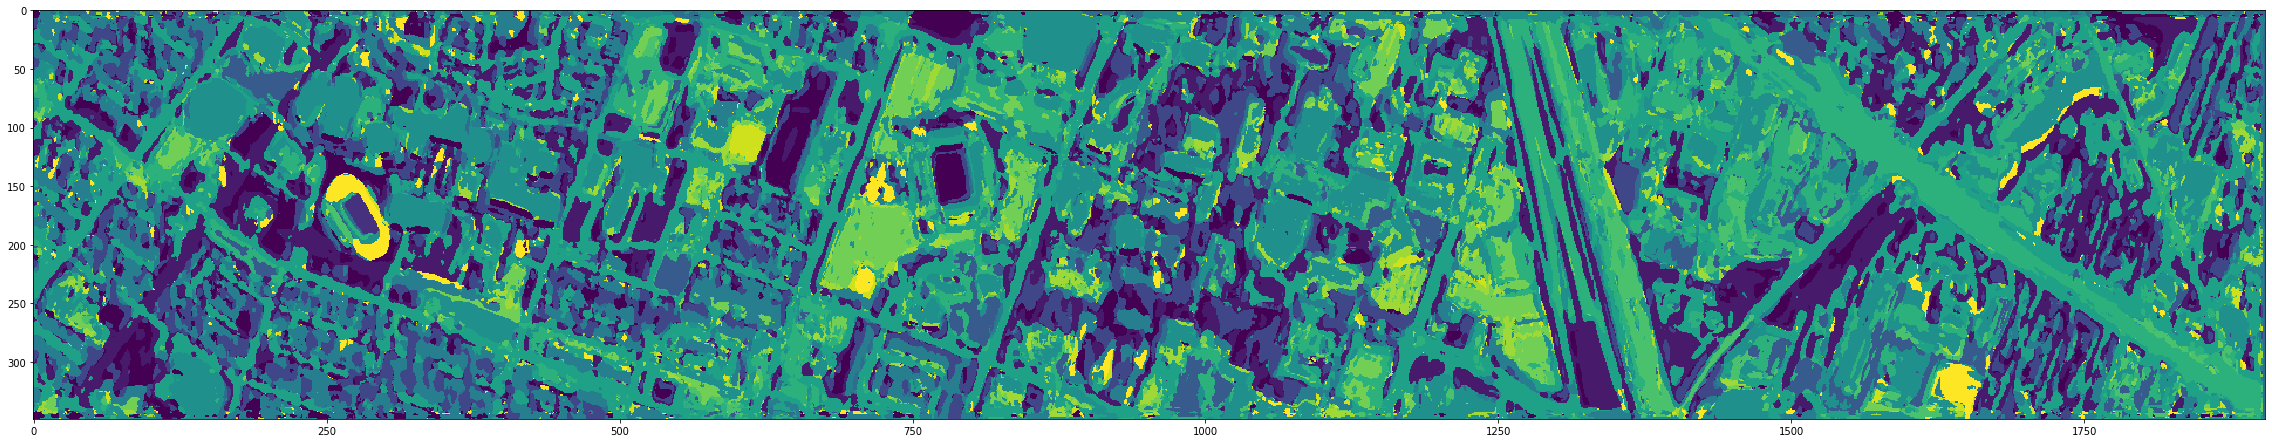

In [19]:
plt.figure(figsize=(40,40))
plt.imshow(pred_all)
plt.show()